In [1]:
%matplotlib inline 

import numpy as np
import scipy
import pandas as pd # pandas
import matplotlib.pyplot as plt # module for plotting 
from mpl_toolkits.mplot3d import Axes3D #3D plotting
import datetime as dt # module for manipulating dates and times

import requests 
import scipy.stats as stats
import statsmodels.api as sm
from scipy.stats import binom
from __future__ import division
import re
from StringIO import StringIO
from zipfile import ZipFile 
from pandas import read_csv
from urllib import urlopen
import urllib2
import json

import sklearn
import sklearn.preprocessing
import sklearn.datasets

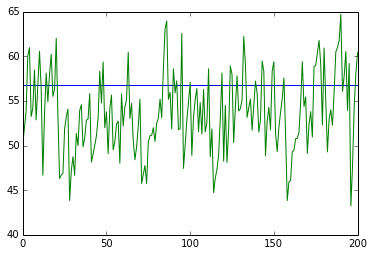

In [22]:
# LMSR Implementation Das Interpretation
# according to http://www.cse.wustl.edu/~mithunchakraborty/papers/AAAI15poster_final.pdf
iterations = 201
trial = np.zeros(100)

for i in np.arange(0,100,1):
    # Initialize Market Model
    initialValue = np.random.normal(50,12)
    if initialValue < 0:
        initialValue = 0
    if initialValue > 100:
        initialValue = 100

    # shock values
    shock_prob= 1/100
    shockSD = 5
    # true asset value
    trueValue = np.zeros(iterations)
    trueValue[0] = initialValue

    # Initial Trade Values
    traderAlphaExponential = 20
    traderSD = 5
    traderValueAll = np.zeros(iterations)
    traderValueAll[0] = initialValue
    
    #initial MM values
    MMb = 125
    MMquantity = np.zeros(iterations)
    MMquantity[0] = 0
    MMprice = np.zeros(iterations)
    MMprice[0] = 50
    MMrevenue = np.zeros(iterations)
    MMrevenue[0] = 0
    for time in np.arange(1,iterations,1):
        if np.random.binomial(1,shock_prob) == 1:
            initialValue = initialValue + np.random.normal(0, shockSD)
        trueValue[time] = initialValue
        traderValue = np.random.normal(initialValue, traderSD)
        traderValueAll[time] = traderValue
        if traderValue <= 0:
            traderValue = 0.01
        if traderValue > 100:
            traderValue = 99.99
        quantityTrader = np.random.exponential(traderAlphaExponential)
        if traderValue < MMprice[time - 1]:
            quantityTrader = -quantityTrader
        currentquantity = np.sum(MMquantity)
        quantityEquivalentprice = (np.log((traderValue/100)/(1-(traderValue/100)))*MMb-currentquantity)
        quantityTrader = min(quantityTrader, quantityEquivalentprice)
        MMquantity[time] = quantityTrader 
        newquantity = quantityTrader + currentquantity
        MMrevenue[time] = 100*MMb*(np.log(1+np.exp(newquantity/MMb))- \
                                   np.log(1+np.exp(currentquantity/MMb)))
        MMprice[time] = 100*(np.exp(newquantity/MMb)/(1+np.exp(newquantity/MMb)))
    trial[i] = np.sum(MMrevenue)
xs = np.arange(0,iterations,1)
plt.plot(xs, trueValue, xs, MMprice)

-217.663568619
3674.83126056
-6744.97365543


(array([  8.,  20.,  23.,  22.,  14.,   8.,   3.,   0.,   1.,   1.]),
 array([ -6744.97365543,  -4647.83186889,  -2550.69008235,   -453.54829581,
          1643.59349074,   3740.73527728,   5837.87706382,   7935.01885036,
         10032.1606369 ,  12129.30242344,  14226.44420998]),
 <a list of 10 Patch objects>)

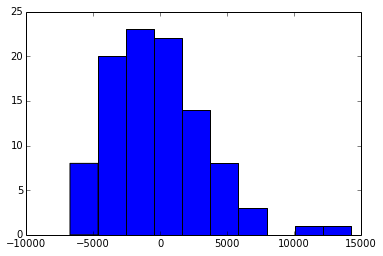

In [23]:
# Revenue Results 
print(np.average(trial))
print(np.std(trial))
print(np.min(trial))
plt.hist(trial)

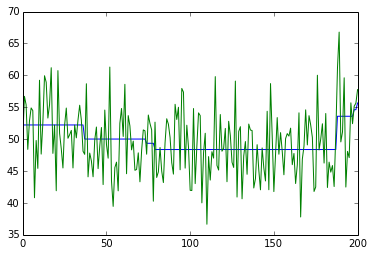

In [24]:
# LMSR Implementation Textbook Interpretation
iterations = 201
trial = np.zeros(101)

for i in np.arange(0,100,1):
    # Initialize Market Model
    initialValue = np.random.normal(50,12)
    if initialValue < 0:
        initialValue = 0
    if initialValue > 100:
        initialValue = 100

    # shock values
    shock_prob= 1/100
    shockSD = 5
    # true asset value
    trueValue = np.zeros(iterations)
    trueValue[0] = initialValue

    # Initial Trade Values
    traderAlphaExponential = 20
    traderSD = 5
    traderValueAll = np.zeros(iterations)
    traderValueAll[0] = initialValue
    
    #initial MM values
    MMb = 125
    MMquantity = np.zeros(iterations)
    MMquantity[0] = 0
    MMprice = np.zeros(iterations)
    MMprice[0] = 50
    MMrevenue = np.zeros(iterations)
    MMrevenue[0] = 0
    
    for time in np.arange(1,iterations,1):
        if np.random.binomial(1,shock_prob) == 1:
            initialValue = initialValue + np.random.normal(0, shockSD)
        trueValue[time] = initialValue
        traderValue = np.random.normal(initialValue, traderSD)
        traderValueAll[time] = traderValue
        if traderValue <= 0:
            traderValue = 0.01
        if traderValue >= 100:
            traderValue = 99.99   
        # will trade till the instantaneous price is equal to trader's value 
        currentquantity = np.sum(MMquantity) 
        quantityTrader = (np.log((traderValue/100)/(1-(traderValue/100)))*MMb-currentquantity)
        MMquantity[time] = quantityTrader
        newquantity = quantityTrader + currentquantity
        MMrevenue[time] = 100*MMb*(np.log(1+np.exp(newquantity/MMb))- \
                                   np.log(1+np.exp(currentquantity/MMb)))
        
        MMprice[time] = 100*(np.exp(newquantity/MMb)/(1+np.exp(newquantity/MMb)))
    trial[i] = np.sum(MMrevenue)
xs = np.arange(0,iterations,1)
plt.plot(xs, trueValue, xs, MMprice)


769.719583248
5051.0903059
-7852.81294739


(array([  6.,  24.,  30.,  15.,  11.,   6.,   4.,   2.,   2.,   1.]),
 array([ -7852.81294739,  -5106.57274001,  -2360.33253264,    385.90767474,
          3132.14788211,   5878.38808949,   8624.62829687,  11370.86850424,
         14117.10871162,  16863.348919  ,  19609.58912637]),
 <a list of 10 Patch objects>)

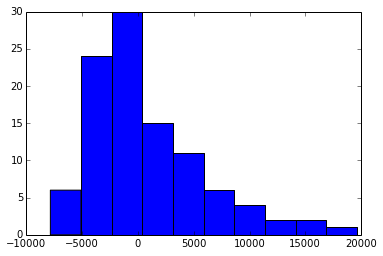

In [26]:
print(np.average(trial))
print(np.std(trial))
print(np.min(trial))
plt.hist(trial)

In [ ]:
#Liquidity Sensitive LMSR Implementation Das Interpretation

iterations = 201
trial = np.zeros(100)

for i in np.arange(0,100,1):
    # Initialize Market Model
    initialValue = np.random.normal(50,12)
    if initialValue < 0:
        initialValue = 0
    if initialValue > 100:
        initialValue = 100

    # shock values
    shock_prob= 1/100
    shockSD = 5
    # true asset value
    trueValue = np.zeros(iterations)
    trueValue[0] = initialValue

    # Initial Trade Values
    traderAlphaExponential = 20
    traderSD = 5
    traderValueAll = np.zeros(iterations)
    traderValueAll[0] = initialValue
    
    #initial MM values
    MMquantity = np.zeros(iterations)
    MMquantity[0] = 10
    MMprice = np.zeros(iterations)
    MMprice[0] = 50
    MMrevenue = np.zeros(iterations)
    MMrevenue[0] = 0
    alpha = 0.05
    
    for time in np.arange(1,iterations,1):
        if np.random.binomial(1,shock_prob) == 1:
            initialValue = initialValue + np.random.normal(0, shockSD)
        trueValue[time] = initialValue
        traderValue = np.random.normal(initialValue, traderSD)
        traderValueAll[time] = traderValue
        if traderValue <= 0:
            traderValue = 0.01
        if traderValue > 100:
            traderValue = 99.99
        quantityTrader = np.random.exponential(traderAlphaExponential)
        if traderValue > MMprice[time - 1]:
            quantityTrader = -quantityTrader
        currentquantity = np.sum(MMquantity)
        totalquantity = np.sum(np.abs(MMquantity))
        MMb = alpha*totalquantity
        MMquantity[time] = quantityTrader     
        newquantity = quantityTrader + currentquantity
        MMrevenue[time] = 100*MMb*(np.log(1+np.exp(newquantity/MMb))- \
                                   np.log(1+np.exp(currentquantity/MMb)))
        MMprice[time] = 100*(alpha*np.log(1+np.exp(newquantity/MMb)))
    trial[i] = np.sum(MMrevenue)
xs = np.arange(0,iterations,1)
plt.plot(xs, trueValue, xs, MMprice)

In [ ]:
print(np.average(trial))
print(np.std(trial))
print(np.min(trial))
plt.hist(trial)